In [6]:
import pandas as pd
import yfinance as yf
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller



In [2]:
ticker= input("Enter the ticker symbol: ")
stock =yf.Ticker(f"{ticker}")
df = stock.history(period="1y")[::-1]

In [3]:
close = df['Close'].values
delta = np.zeros_like(close)
delta[1:] = np.where(close[:-1] != 0, (close[1:] / close[:-1]) - 1, 0)


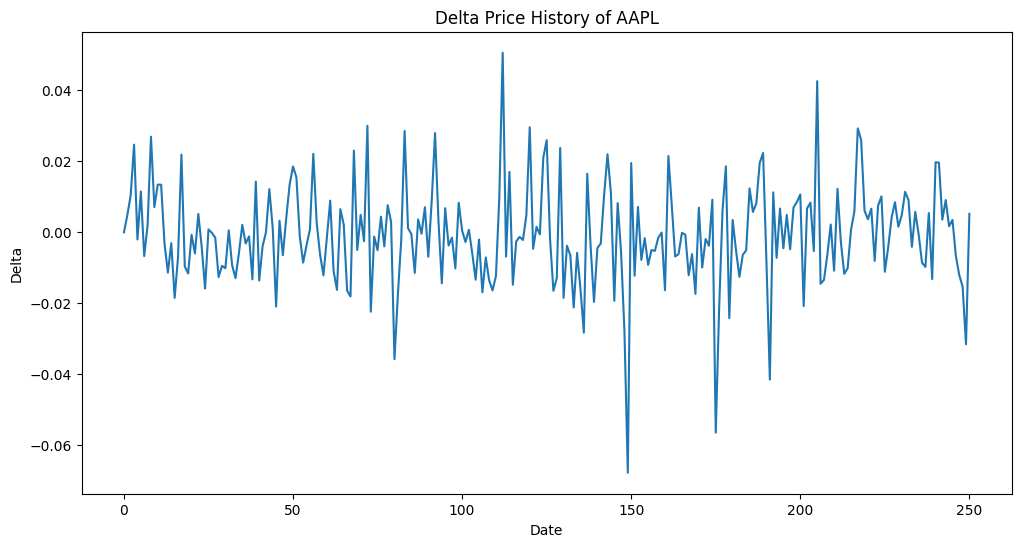

In [4]:
#Graphing the delta vs time
plt.figure(figsize=(12,6))
plt.plot(delta, label='Delta Price history')
plt.title(f'Delta Price History of {ticker}')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.show()

In [23]:

# Calculate percentage change
df['delta'] = df['Close'].pct_change() * 100

# Remove NaN values that result from pct_change()
df_clean = df.dropna()

def perform_adf_test(data):
    """
    Perform Augmented Dickey-Fuller test on a time series and print detailed results
    
    Parameters:
    data (Series): Pandas Series containing the time series data
    
    Returns:
    dict: Dictionary containing test statistics and critical values
    """
    # Perform ADF test
    result = adfuller(data)
    
    # Print detailed results
    print('ADF Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('\nCritical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    # Interpretation
    print('\nInterpretation:')
    if result[1] < 0.05:
        print('Series is stationary (reject null hypothesis)')
    else:
        print('Series is non-stationary (fail to reject null hypothesis)')
    
    return result

# Run the test on the clean data
adf_result = perform_adf_test(df_clean['delta'])

# Print some basic statistics about the delta
print('\nBasic Statistics of Percentage Changes:')
print(df_clean['delta'].describe())

ADF Test Results:
ADF Statistic: -14.875482586811632
p-value: 1.6390119867406138e-27

Critical Values:
	1%: -3.4568881317725864
	5%: -2.8732185133016057
	10%: -2.5729936189738876

Interpretation:
Series is stationary (reject null hypothesis)

Basic Statistics of Percentage Changes:
count    250.000000
mean      -0.089447
std        1.415241
min       -6.772872
25%       -0.901980
50%       -0.162020
75%        0.690340
max        5.060441
Name: delta, dtype: float64


In [5]:
def run_garch_analysis(returns, p=1, q=1):
    """
    Run a GARCH(p,q) model on return series
    
    Parameters:
    returns: numpy array of return values
    p: ARCH term order (default=1)
    q: GARCH term order (default=1)
    
    Returns:
    model_fit: fitted GARCH model
    summary: model summary
    forecasts: volatility forecasts
    """
    # Remove any infinite or NaN values
    returns = returns[np.isfinite(returns)]
    
    # Fit GARCH model
    model = arch_model(returns * 100, vol='Garch', p=p, q=q, mean='Zero')
    model_fit = model.fit(disp='off')
    
    # Generate volatility forecasts
    forecasts = model_fit.forecast(horizon=5)
    
    return model_fit, model_fit.summary(), forecasts

def analyze_volatility(close_prices):
    """
    Analyze volatility using the provided close prices
    
    Parameters:
    close_prices: numpy array of closing prices
    """
    # Calculate returns
    delta = np.zeros_like(close_prices)
    delta[1:] = np.where(close_prices[:-1] != 0, 
                        (close_prices[1:] / close_prices[:-1]) - 1, 
                        0)
    
    # Run GARCH analysis
    model_fit, summary, forecasts = run_garch_analysis(delta)
    
    # Calculate annualized volatility (assuming daily data)
    annual_vol = np.sqrt(252) * np.sqrt(model_fit.conditional_volatility)
    
    return {
        'model_fit': model_fit,
        'summary': summary,
        'forecasts': forecasts,
        'annual_volatility': annual_vol
    }
#Summary stats
if __name__ == "__main__":
    # Using the provided close prices
    results = analyze_volatility(close)
    
    print("\nModel Summary:")
    print(results['summary'])
    
    print("\nVolatility Forecast (next 5 periods):")
    print(results['forecasts'].variance.iloc[-1])
    
    print("\nLatest Annualized Volatility:")
    print(f"{results['annual_volatility'][-1]:.2%}")


Model Summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -440.441
Distribution:                  Normal   AIC:                           886.882
Method:            Maximum Likelihood   BIC:                           897.458
                                        No. Observations:                  251
Date:                Tue, Jan 14 2025   Df Residuals:                      251
Time:                        17:30:23   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0214  1.931e-02      1

This model can be improved tbh